In [1]:
import sys
sys.path.append("..")

import jax, os, corner
import jax.numpy as jnp
from jax import grad, config
import matplotlib.pyplot as plt
import numpy as np
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)
from functools import partial

# Load reparameterization methods
from src.reparameterization import reparameterization, sigma, logistic_CDF

In [2]:
### Define gravitational wave model ###

from models.taylorf2 import taylorf2

# Emulation of a binary neutron star system 
injection = jnp.array([0, 0, 1.2, 0.245, 0.05]) 

priorDict = {}
priorDict[0] = injection[0] + jnp.array([-0.001, 0.001])
priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
# priorDict[2] = jnp.array([0.1, 2])
priorDict[2] = jnp.array([1.175, 1.225])
priorDict[3] = jnp.array([0.2, 0.249])
priorDict[4] = jnp.array([0.02, 0.07])

model = taylorf2(injection, priorDict)

SNR is: 17.09462262749192


In [3]:
def birthDeathJumpIndicies(key, Y, V, tau, h):
    """ 
    Remarks
    -------

    (1) Uses discrepancy from original paper
    (2) uses discrepancy from sequal paper

    """
    nParticles = V.shape[0]
    key, subkey = jax.random.split(key)

    # Lp kernel implementation
    def k_lp(X, p=2, h=0.01): 
        # Get separation vectors
        separation_vectors = X[:, jnp.newaxis, :] - X[jnp.newaxis, :, :]
        
        # Calculate kernel
        k = jnp.exp(-jnp.sum(jnp.abs(separation_vectors) ** p, axis=-1) / (p * h))
        return k

    kern_bd = k_lp(Y, h=h)

    # Get particles with significant mass discrepancy (1)
    # beta = jnp.log(jnp.mean(kern_bd, axis=1)) + V
    # Lambda = beta - jnp.mean(beta) 

    # Get particles with significant mass discrepancy (2)
    tmp1 = jnp.mean(kern_bd, axis=1)
    Lambda = jnp.log(tmp1) + V
    Lambda = Lambda - jnp.mean(Lambda) - 1 + jnp.mean(kern_bd / tmp1, axis=1)

    # Calculate number of events
    r = jax.random.uniform(minval=0, maxval=1, shape=Lambda.shape, key=key)
    threshold = r < 1 - jnp.exp(-jnp.abs(Lambda) * tau)

    randomized_indicies_1 = jax.random.permutation(key, jnp.arange(nParticles))

    excess_particles = jnp.logical_and(threshold, Lambda > 0)
    deficit_particles = jnp.logical_and(threshold, Lambda < 0)

    # Case 1: Mass excess
    output = jnp.where(excess_particles, randomized_indicies_1, jnp.arange(nParticles)) 

    # Case 2: Mass deficit
    random_mask = jax.random.permutation(key, deficit_particles)
    aligned = jax.random.permutation(key, jnp.arange(nParticles))
    output = jnp.where(random_mask, aligned, output)

    return output

In [7]:
def ula_kernel(key, param, log_post, grad_log_post, dt):
    """ 
    Remarks
    -------
    
    (1) grad_log_post is the gradient of the potential. Change name of this later
    (2) 
    
    """
    key, subkey = jax.random.split(key)

    paramGrad = grad_log_post(param)

    V_X = log_post(param)

    # Transform to unbounded domain (currently includes potential calculation for eventual birth-death step)
    Y, V_Y, gmlpt_Y = reparameterization(param, V_X, paramGrad, model.lower_bound, model.upper_bound)

    # Get jumps
    jumps = birthDeathJumpIndicies(key, Y, V_Y, 1e-2, h=0.01)

    # Perform update in unbounded domain
    Y = Y[jumps] - gmlpt_Y[jumps] * dt + jnp.sqrt(2 * dt) * jax.random.normal(key=subkey, shape=(param.shape))

    # Convert samples back to bounded domain 
    param = sigma(logistic_CDF(Y), model.lower_bound, model.upper_bound)

    return key, param

@partial(jax.jit, static_argnums=(1,2,3))
def ula_sampler_full_jax_jit(key, log_post, grad_log_post, n_iter, dt, x_0):

    # @progress_bar_scan(n_iter)
    def ula_step(carry, x):
        key, param = carry
        key, param = ula_kernel(key, param, log_post, grad_log_post, dt)
        return (key, param), param

    carry = (key, x_0)
    _, samples = jax.lax.scan(ula_step, carry, None, n_iter)
    return samples

In [14]:
n_iter = 30000
n_particles = 500
eps = 1e-4
X0 = model._newDrawFromPrior(n_particles)
key = jax.random.PRNGKey(0)

# Run sampler
sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, X0)



buffer in prior: 0.000000
buffer in prior: 0.000000
buffer in prior: 0.000000
buffer in prior: 0.000000
buffer in prior: 0.000000


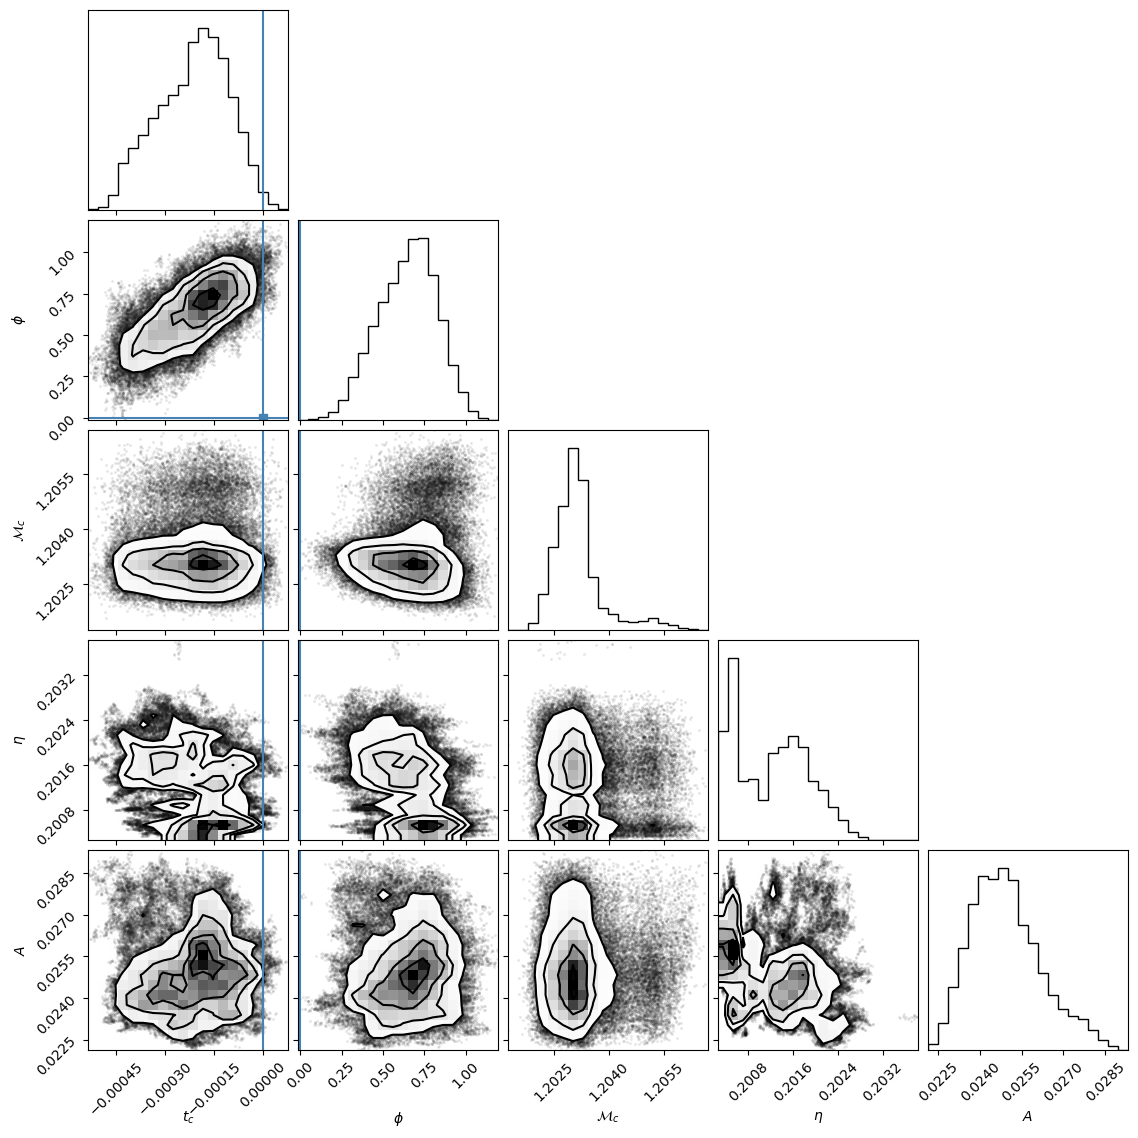

In [15]:
# Plot samples
reshaped_matrix = sam.reshape((n_iter * n_particles, model.DoF))
fig = corner.corner(reshaped_matrix[-100000:], hist_kwargs={'density':True}, labels=model.index_label, truths=injection)